In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import datetime

%reload_ext tensorboard

In [2]:
 print(tf.__version__)

2.0.0-rc1


In [3]:
df = pd.read_csv("./heart.csv")

In [4]:
df.head(10)#See the first 10 rows

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


In [5]:
df.shape #Shape of the dataset

(303, 14)

In [6]:
df.isnull().values.any() #Check whether there is NULL value

False

In [7]:
df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

In [8]:
df1= df.copy()
#Removed categorical features to check the pairplot
df1.drop(['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal','target'], axis=1, inplace=True)
df1.head()

,age,trestbps,chol,thalach,oldpeak
0,63,145,233,150,2.3
1,37,130,250,187,3.5
2,41,130,204,172,1.4
3,56,120,236,178,0.8
4,57,120,354,163,0.6


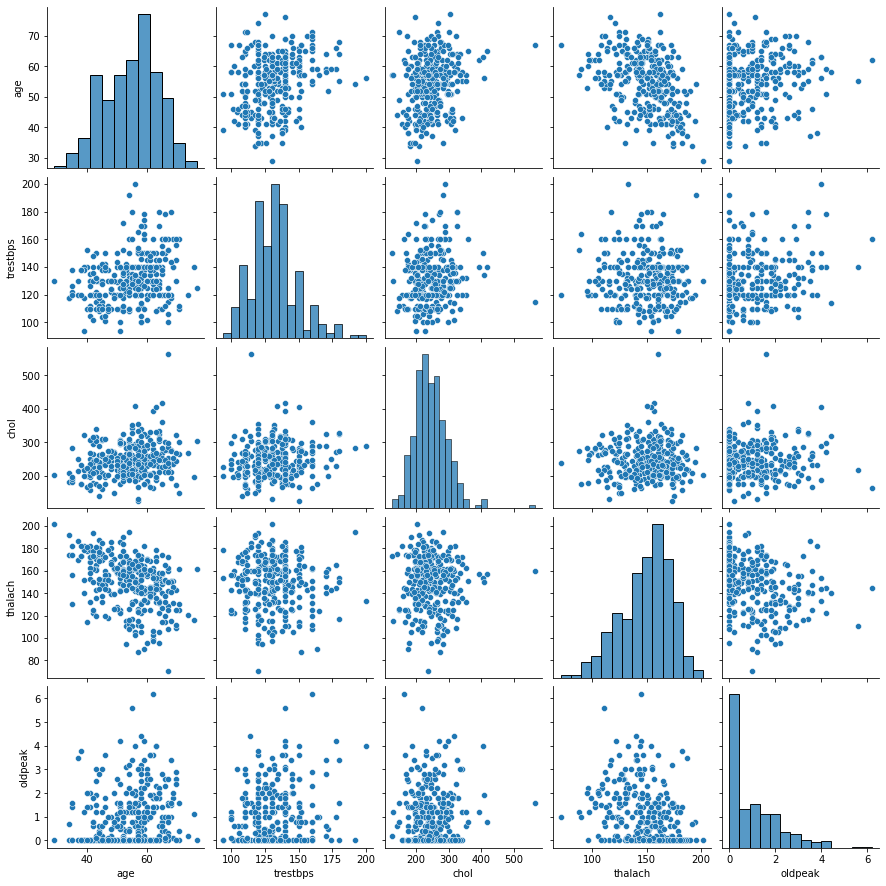

In [9]:
g = sns.pairplot(df1)

In [10]:
df = df[df['oldpeak']<5] 
df=  df[df['chol']<500]
df.shape

(300, 14)

In [11]:
df1= df.copy()
df1.drop(['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal','target'], axis=1, inplace=True)
df1.head()

,age,trestbps,chol,thalach,oldpeak
0,63,145,233,150,2.3
1,37,130,250,187,3.5
2,41,130,204,172,1.4
3,56,120,236,178,0.8
4,57,120,354,163,0.6


In [12]:
def calc_limits(feature):
    q1,q3=df[feature].quantile([0.25,0.75])
    iqr=q3-q1
    rang=1.5*iqr
    return(q1-rang,q3+rang)
for col in df1.columns:
    lower,upper=calc_limits(col)
    df = df[(df[col] >lower) & (df[col]<upper)]
df.shape

(279, 14)

In [13]:
df2 = df.copy()
df2.drop(['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal','target'], axis=1, inplace=True)
df2.head()

,age,trestbps,chol,thalach,oldpeak
0,63,145,233,150,2.3
1,37,130,250,187,3.5
2,41,130,204,172,1.4
3,56,120,236,178,0.8
4,57,120,354,163,0.6


In [14]:
X=df2.values
y=df['target'].values
train_index = np.random.choice(len(X), round(len(X) * 0.7), replace=False)
test_index = np.array(list(set(range(len(X))) - set(train_index)))
x_train = X[train_index]
y_train = y[train_index]
x_test = X[test_index]
y_test = y[test_index]
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
x_train, x_test = x_train.reshape([-1, 5]), x_test.reshape([-1, 5])

y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

In [15]:
#Normalizing the x values
def min_max_normalized(data):
    col_max = np.max(data, axis=0)
    col_min = np.min(data, axis=0)
    return np.divide(data - col_min, col_max - col_min)
x_train = min_max_normalized(x_train)
x_test = min_max_normalized(x_test)

weights =  tf.Variable(tf.ones(shape=[5, 1], name="weights"))
bias = tf.Variable(tf.zeros([1 , 1]), name= "bias")

In [16]:
def logistic_regression(x):
    lr = tf.add(tf.matmul(x, weights), bias)
    #return tf.nn.sigmoid(lr)
    return lr


def cross_entropy(y_true, y_pred):   #loss function
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred)
    return tf.reduce_mean(loss)

def accuracy(y_true, y_pred, x):   #to determine the accuracy
    preds =  tf.round(tf.sigmoid(tf.add(tf.matmul(x, weights), bias)))
    preds = tf.equal(y_true, preds)
    return tf.reduce_mean(tf.cast(preds, dtype=tf.float32))


# optimizer
def grad(x, y):       
    with tf.GradientTape() as tape:
        y_pred = logistic_regression(x)
        loss_val = cross_entropy(y, y_pred)
    gradients = tape.gradient(loss_val, [weights, bias])
    optimizer.apply_gradients(zip(gradients, [weights, bias]))
    
    
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)

#Hyperparameters
n_batches = 1000
learning_rate = 0.01
batch_size = 20

#To shuffle and Batch the data
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.repeat().shuffle(5000).batch(batch_size).prefetch(1)

optimizer = tf.optimizers.SGD(learning_rate)

In [17]:
for batch_numb, (batch_xs, batch_ys) in enumerate(dataset.take(n_batches), 1):
    grad(batch_xs, batch_ys)
    y_pred = logistic_regression(batch_xs)
    loss = cross_entropy(batch_ys, y_pred)
    acc = accuracy(batch_ys, y_pred, batch_xs)
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', loss, step=batch_numb)
        tf.summary.scalar('accuracy', acc, step=batch_numb)
    
    print("Epoch: %i, loss: %f, train_accuracy: %f" % (batch_numb, loss, acc))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch: 1, loss: 1.231405, train_accuracy: 0.550000
Epoch: 2, loss: 1.109806, train_accuracy: 0.600000
Epoch: 3, loss: 1.197427, train_accuracy: 0.600000
Epoch: 4, loss: 1.218583, train_accuracy: 0.550000
Epoch: 5, loss: 1.498307, train_accuracy: 0.450000
Epoch: 6, loss: 0.968472, train_accuracy: 0.600000
Epoch: 7, loss: 0.869722, train_accuracy: 0.650000
Epoch: 8, loss: 1.335887, train_accuracy: 0.450000
Epoch: 9, loss: 1.321878, train_accuracy: 0.450000
Epoch: 10, loss: 0.986816, train_accuracy: 0.650000
Epoch: 11, loss: 1.159045, train_accuracy: 0.600000
Epoch: 12, loss: 1.198156, train_accuracy: 0.550000
Epoch: 13, loss: 1.493587, train_accuracy: 0.450000
Epoch: 14, loss: 1.473847, train_accuracy: 0.400000
Epoch: 15, loss: 1.072235, train_accuracy: 0.600000
Epoch: 16, loss: 1.400831, train_accuracy: 0.450000
Epoch: 17, loss: 1.268111, train_accuracy: 0.500000
Epoch: 18, loss: 0.842757, trai

Epoch: 167, loss: 0.769102, train_accuracy: 0.600000
Epoch: 168, loss: 0.755968, train_accuracy: 0.650000
Epoch: 169, loss: 0.784347, train_accuracy: 0.550000
Epoch: 170, loss: 1.003509, train_accuracy: 0.500000
Epoch: 171, loss: 0.801921, train_accuracy: 0.550000
Epoch: 172, loss: 0.890961, train_accuracy: 0.500000
Epoch: 173, loss: 0.821331, train_accuracy: 0.600000
Epoch: 174, loss: 0.682875, train_accuracy: 0.650000
Epoch: 175, loss: 0.694491, train_accuracy: 0.700000
Epoch: 176, loss: 0.885879, train_accuracy: 0.550000
Epoch: 177, loss: 0.970868, train_accuracy: 0.500000
Epoch: 178, loss: 0.955838, train_accuracy: 0.450000
Epoch: 179, loss: 0.762242, train_accuracy: 0.600000
Epoch: 180, loss: 1.001413, train_accuracy: 0.500000
Epoch: 181, loss: 0.981206, train_accuracy: 0.500000
Epoch: 182, loss: 0.690991, train_accuracy: 0.750000
Epoch: 183, loss: 0.878337, train_accuracy: 0.500000
Epoch: 184, loss: 0.781139, train_accuracy: 0.550000
Epoch: 185, loss: 0.689627, train_accuracy: 0.

Epoch: 325, loss: 0.703745, train_accuracy: 0.700000
Epoch: 326, loss: 0.837329, train_accuracy: 0.450000
Epoch: 327, loss: 0.641261, train_accuracy: 0.700000
Epoch: 328, loss: 0.695867, train_accuracy: 0.650000
Epoch: 329, loss: 0.654233, train_accuracy: 0.650000
Epoch: 330, loss: 0.814700, train_accuracy: 0.500000
Epoch: 331, loss: 0.732502, train_accuracy: 0.550000
Epoch: 332, loss: 0.837567, train_accuracy: 0.500000
Epoch: 333, loss: 0.709725, train_accuracy: 0.650000
Epoch: 334, loss: 0.709101, train_accuracy: 0.600000
Epoch: 335, loss: 0.780110, train_accuracy: 0.600000
Epoch: 336, loss: 0.774797, train_accuracy: 0.550000
Epoch: 337, loss: 0.683351, train_accuracy: 0.600000
Epoch: 338, loss: 0.603214, train_accuracy: 0.750000
Epoch: 339, loss: 0.646508, train_accuracy: 0.700000
Epoch: 340, loss: 0.769441, train_accuracy: 0.550000
Epoch: 341, loss: 0.658267, train_accuracy: 0.650000
Epoch: 342, loss: 0.978928, train_accuracy: 0.250000
Epoch: 343, loss: 0.698667, train_accuracy: 0.

Epoch: 485, loss: 0.735621, train_accuracy: 0.550000
Epoch: 486, loss: 0.665466, train_accuracy: 0.600000
Epoch: 487, loss: 0.715232, train_accuracy: 0.500000
Epoch: 488, loss: 0.866604, train_accuracy: 0.300000
Epoch: 489, loss: 0.872764, train_accuracy: 0.350000
Epoch: 490, loss: 0.711543, train_accuracy: 0.500000
Epoch: 491, loss: 0.688485, train_accuracy: 0.700000
Epoch: 492, loss: 0.727801, train_accuracy: 0.550000
Epoch: 493, loss: 0.728112, train_accuracy: 0.450000
Epoch: 494, loss: 0.672027, train_accuracy: 0.500000
Epoch: 495, loss: 0.695681, train_accuracy: 0.600000
Epoch: 496, loss: 0.684362, train_accuracy: 0.500000
Epoch: 497, loss: 0.667162, train_accuracy: 0.650000
Epoch: 498, loss: 0.674308, train_accuracy: 0.550000
Epoch: 499, loss: 0.757707, train_accuracy: 0.500000
Epoch: 500, loss: 0.660513, train_accuracy: 0.600000
Epoch: 501, loss: 0.572306, train_accuracy: 0.850000
Epoch: 502, loss: 0.696221, train_accuracy: 0.600000
Epoch: 503, loss: 0.645147, train_accuracy: 0.

Epoch: 647, loss: 0.663923, train_accuracy: 0.600000
Epoch: 648, loss: 0.703623, train_accuracy: 0.600000
Epoch: 649, loss: 0.693388, train_accuracy: 0.500000
Epoch: 650, loss: 0.768347, train_accuracy: 0.500000
Epoch: 651, loss: 0.708802, train_accuracy: 0.500000
Epoch: 652, loss: 0.674846, train_accuracy: 0.600000
Epoch: 653, loss: 0.714450, train_accuracy: 0.500000
Epoch: 654, loss: 0.739826, train_accuracy: 0.500000
Epoch: 655, loss: 0.723457, train_accuracy: 0.500000
Epoch: 656, loss: 0.679584, train_accuracy: 0.600000
Epoch: 657, loss: 0.755756, train_accuracy: 0.450000
Epoch: 658, loss: 0.660464, train_accuracy: 0.650000
Epoch: 659, loss: 0.742858, train_accuracy: 0.550000
Epoch: 660, loss: 0.687314, train_accuracy: 0.550000
Epoch: 661, loss: 0.648628, train_accuracy: 0.600000
Epoch: 662, loss: 0.659127, train_accuracy: 0.700000
Epoch: 663, loss: 0.687412, train_accuracy: 0.700000
Epoch: 664, loss: 0.724029, train_accuracy: 0.450000
Epoch: 665, loss: 0.693581, train_accuracy: 0.

Epoch: 803, loss: 0.608788, train_accuracy: 0.650000
Epoch: 804, loss: 0.760985, train_accuracy: 0.400000
Epoch: 805, loss: 0.744647, train_accuracy: 0.550000
Epoch: 806, loss: 0.665752, train_accuracy: 0.700000
Epoch: 807, loss: 0.650018, train_accuracy: 0.600000
Epoch: 808, loss: 0.664854, train_accuracy: 0.650000
Epoch: 809, loss: 0.684387, train_accuracy: 0.550000
Epoch: 810, loss: 0.691062, train_accuracy: 0.700000
Epoch: 811, loss: 0.765412, train_accuracy: 0.450000
Epoch: 812, loss: 0.650010, train_accuracy: 0.550000
Epoch: 813, loss: 0.664930, train_accuracy: 0.650000
Epoch: 814, loss: 0.724089, train_accuracy: 0.500000
Epoch: 815, loss: 0.712898, train_accuracy: 0.450000
Epoch: 816, loss: 0.667149, train_accuracy: 0.600000
Epoch: 817, loss: 0.630901, train_accuracy: 0.800000
Epoch: 818, loss: 0.616225, train_accuracy: 0.750000
Epoch: 819, loss: 0.650976, train_accuracy: 0.750000
Epoch: 820, loss: 0.670105, train_accuracy: 0.550000
Epoch: 821, loss: 0.629174, train_accuracy: 0.

Epoch: 962, loss: 0.742937, train_accuracy: 0.500000
Epoch: 963, loss: 0.681664, train_accuracy: 0.550000
Epoch: 964, loss: 0.721702, train_accuracy: 0.500000
Epoch: 965, loss: 0.703883, train_accuracy: 0.550000
Epoch: 966, loss: 0.663685, train_accuracy: 0.650000
Epoch: 967, loss: 0.751070, train_accuracy: 0.400000
Epoch: 968, loss: 0.729698, train_accuracy: 0.450000
Epoch: 969, loss: 0.666296, train_accuracy: 0.600000
Epoch: 970, loss: 0.739549, train_accuracy: 0.450000
Epoch: 971, loss: 0.654626, train_accuracy: 0.600000
Epoch: 972, loss: 0.705912, train_accuracy: 0.450000
Epoch: 973, loss: 0.668457, train_accuracy: 0.600000
Epoch: 974, loss: 0.649761, train_accuracy: 0.600000
Epoch: 975, loss: 0.672021, train_accuracy: 0.550000
Epoch: 976, loss: 0.635235, train_accuracy: 0.700000
Epoch: 977, loss: 0.589770, train_accuracy: 0.750000
Epoch: 978, loss: 0.697001, train_accuracy: 0.550000
Epoch: 979, loss: 0.625926, train_accuracy: 0.650000
Epoch: 980, loss: 0.743128, train_accuracy: 0.

In [18]:
pred = logistic_regression(x_test)

print("Test Accuracy: %f" % accuracy(y_test, pred , x_test))

Test Accuracy: 0.547619


In [19]:
%tensorboard --logdir logs/gradient_tape

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Traceback (most recent call last):
  File "c:\users\yash shetty\anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\yash shetty\anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Yash Shetty\anaconda3\Scripts\tensorboard.exe\__main__.py", line 7, in <module>
  File "C:\Users\Yash Shetty\AppData\Roaming\Python\Python37\site-packages\tensorboard\main.py", line 75, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "c:\users\yash shetty\anaconda3\lib\site-packages\absl\app.py", line 303, in run
    _run_main(main, args)
  File "c:\users\yash shetty\anaconda3\lib\site-packages\absl\app.py", line 251, in _run_main
    sys.exit(main(argv))
  File "C:\Users\Yash Shetty\AppData\Roaming\Python\Python37\site-packages\tensorboard\program.py", line 289, in main
    return runner(self.flags) or 0
  File "